# Purpose

Script to take proteomics data output from MS Fragger and TMTintegrator,
and perform significance testing for differentially expressed proteins and peptides 



### Load required R packages and files required for analysis

In [15]:
#setwd("/Users/peterbell/conda_environments/assignment_8/my-book/")

library(dplyr)
library(tidyr)
library(reshape2)
library(ggplot2)
library(gghighlight)
# import peptide level expression data
peptide = read.table("data/abundance_peptide_None.tsv", sep='\t', header = TRUE)
# import .psm.tsv file, to derive semi-tryptics
psm = read.table("data/psm.tsv", sep='\t', header = TRUE)
# import protein expression data
protein = read.table("data/abundance_protein_MD.tsv", sep='\t', header = TRUE) ;

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”


### Process peptide expression data

In [16]:
# impute 0 for all NA abundance values
# note - column subsetting is based on 16-plex TMT
peptide[, 7:22][is.na(peptide[, 7:22])] <- 0

After imputation with 0 for NA values, generate histogram of peptide abundances to determine whether data is normally distributed. Note - imputation with 0 reasonable in this case; less valid where data from multiple TMT-plexes combined.

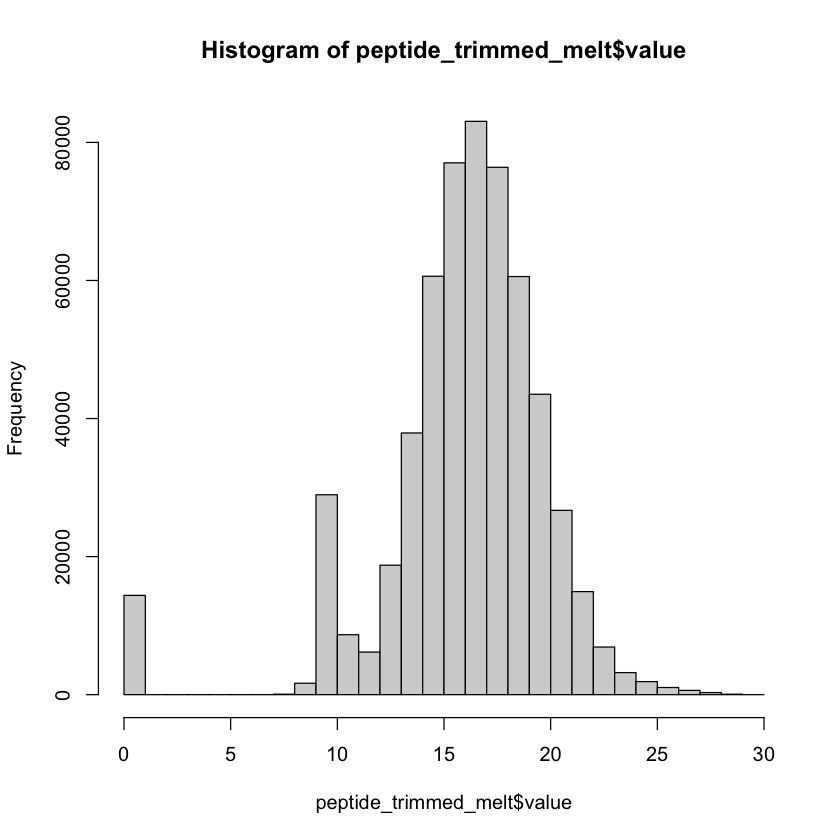

In [17]:
# generate histogram of peptide abundances to determine whether data is normally distributed
peptide_trimmed = peptide[,1:21]
peptide_trimmed = subset(peptide_trimmed, select = -c(sample_01, sample_02, sample_03) )
peptide_trimmed_melt = melt(peptide_trimmed, id.vars=c("Index", "Gene", "ProteinID", "Peptide",
                        "MaxPepProb", "ReferenceIntensity"))
hist(peptide_trimmed_melt$value)

Now that we are confident that log2 tranformed peptide abundance data are normally distributed, we can perform significance testing for differences between peptide abundances derived from SARS-CoV-2 infected cells vs controls

In [19]:
# calculate mean abundance for each condition
peptide$control_mean = rowMeans(peptide[ , c(10, 12, 14, 16, 18, 20)])
peptide$sarscov2_mean = rowMeans(peptide[ , c(11, 13, 15, 17, 19, 21)])

# calculate ratio of abundance note minus because log
peptide$sarscov2_control_ratio = peptide$sarscov2_mean - peptide$control_mean

# perform statistical test for differential expression
for(i in 1:nrow(peptide)) {
  tmp_ttest = t.test(peptide[i,c(10, 12, 14, 16, 18, 20)], y = peptide[i, c(11, 13, 15, 17, 19, 21)]) 
  #print(tmp_ttest$p.value)
  peptide$p_value[i] = tmp_ttest$p.value
}

# correct for multiple testing
peptide$p_adj = p.adjust(peptide$p_value, method = "BH", n = length(peptide$p_value))

### Significance testing

Next we want to determine which peptides do not possess 2 enzymatic termini; i.e. which peptides are 'semi-tryptic'. Having derived a vector containing these peptide sequences, we append this information as a new column: `peptide$semi_tryptic` 

In [39]:
# filter psm for semi-tryptic peptides
psm_semi_tryptic = psm %>% filter(Number.of.Enzymatic.Termini != 2)
# derive a list of unique semi-tryptic peptides
psm_semi_tryptic_peptides = unique(psm_semi_tryptic$Peptide)

# filter peptide data frame for semi_tryptic_peptides
semi_indices = peptide$Peptide %in% psm_semi_tryptic_peptides
peptide_semi_tryptic = peptide[semi_indices,]

# derive vector of semi-tryptic peptides
semi_tryptic_vector = peptide_semi_tryptic$Peptide

# append column onto peptides detailing if peptide sequence
# is semi-tryptic

peptide$semi_tryptic = peptide$Peptide %in% semi_tryptic_vector


Next, we perform significance testing for differences between peptide abundances derived from SARS-CoV-2 infected cells vs controls.
Having derived a vector containing differentially expressed proteins (at FDR-controlled p < 0.05, we append this information to `peptide` as a new column: `peptide$sig_protein`

In [29]:
# impute 0 for all NA abundance values
# note - column subsetting is based on 16-plex
protein[, 6:21][is.na(protein[, 6:21])] <- 0

# calculate mean abundance for each condition
protein$control_mean = rowMeans(protein[ , c(9, 11, 13, 15, 17, 19)])
protein$sarscov2_mean = rowMeans(protein[ , c(10, 12, 14, 16, 18, 20)])

# calculate ratio of abundance
protein$sarscov2_control_ratio = protein$sarscov2_mean / protein$control_mean

# perform statistical test for differential expression
for(i in 1:nrow(protein)) {
  tmp_ttest = t.test(protein[i,c(9, 11, 13, 15, 17, 19)], y = protein[i, c(10, 12, 14, 16, 18, 20)]) 
  #print(tmp_ttest$p.value)
  protein$p_value[i] = tmp_ttest$p.value
}

# correct for multiple testing
protein$p_adj = p.adjust(protein$p_value, method = "BH", n = length(protein$p_value))

# derive vector of significantly different proteins
sig_protein_vector = protein %>% filter(p_adj < 0.05)
sig_protein_vector = sig_protein_vector$Gene

# append column onto peptides detailing if peptide sequence
# is semi-tryptic
peptide$sig_protein = peptide$Gene %in% sig_protein_vector

# derive vector of significantly different peptides
sig_peptide_vector = peptide %>% filter(p_adj < 0.05)
sig_peptide_vector = sig_peptide_vector$Peptide

# append column if peptide is significantly different in quantity
peptide$sig_peptide = peptide$Peptide %in% sig_peptide_vector

### Generate volcano plot

Visualise data 

Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


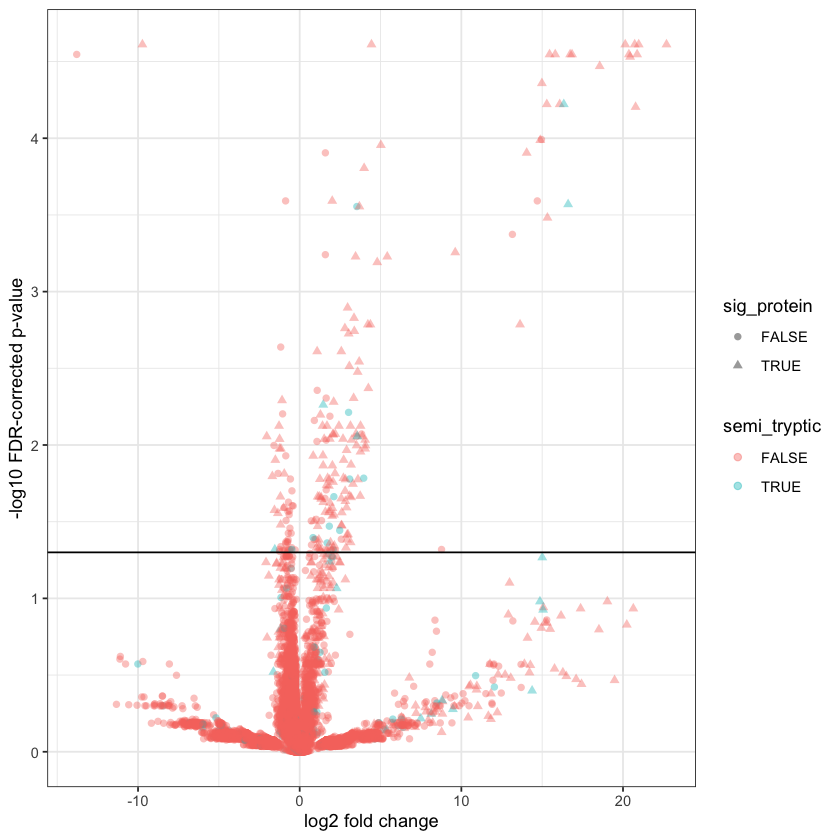

In [38]:

# volcano plot with annotation if semi tryptic and significantly different at protein level
g <- ggplot(data=peptide, 
            aes(x=sarscov2_control_ratio, y =-log10(p_adj), color = semi_tryptic,
                shape = sig_protein, alpha = sig_peptide)) +
  geom_point(alpha=0.4, size=1.75) +
  geom_hline(yintercept = 1.3) +
  #gghighlight(sig_peptide) +
  #xlim(-20,20) +
  xlab("log2 fold change") + ylab("-log10 FDR-corrected p-value") +
  theme_bw() #+
  #theme(legend.position="none")
g